In [1]:
import pandas as pd
import numpy as np
import networkx as nx
from scipy.stats import kendalltau, spearmanr
import scipy.stats
from sklearn import preprocessing
import matplotlib.pyplot as plt
from pandas import DataFrame
from itertools import chain
import cv2
from PIL import Image
import os
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

2025-01-10 13:33:41.165297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import tensorflow.compat.v1 as tf
tf.disable_eager_execution() 
print(tf.__version__)

2.12.0


# 训练

In [4]:
srcPath = '/home/zkl/Desktop/SV-CCI_results/Lung/step3/pic/resize/'
#srcPath = '/home/zkl/Desktop/CAE/pictures/resize/'   # 所要读取的文件夹
filelist = os.listdir(srcPath)
list1=[]
# 读取图片
for filename in filelist:
    filename1 = os.path.splitext(filename)[1]  # 读取文件后缀名
    filename0 = os.path.splitext(filename)[0]  # 读取文件名
    list1.append(filename0+filename1)

In [5]:
len(list1)

1227

In [8]:
x = []
for i in range(100):#range(len(list1)-40):
    path = srcPath+list1[i]
    img = Image.open(path)
    image_matrix = np.array(img)
    x.append(image_matrix)
x_train = np.array(x)

In [6]:
x = []
for i in range(len(list1)-100,len(list1)):
    path = srcPath+list1[i]
    img = Image.open(path)
    image_matrix = np.array(img)
    x.append(image_matrix)
x_test = np.array(x)

In [10]:
x_test.shape

(100, 720, 800)

In [12]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_train.shape,x_test.shape

((100, 720, 800, 1), (100, 720, 800, 1))

In [13]:
#归一化
#x_train = tf.cast(x_train,tf.float32) /255
#x_test = tf.cast(x_test,tf.float32) /255
x_train = x_train.astype('float32') /255
x_test = x_test.astype('float32') /255

In [11]:
x_train.shape[:]

(100, 720, 800)

In [14]:
#卷积去噪自编码器模型
input = tf.keras.layers.Input(shape=x_train.shape[1:])

#encode 
x1 = tf.keras.layers.Conv2D(32,(3,3),activation='relu',padding='same')(input)                #28,28,16
x2 = tf.keras.layers.MaxPooling2D(padding='same')(x1)                                         #14,14,16

x3 = tf.keras.layers.Conv2D(16,(3,3),activation='relu',padding='same')(x2)                #14,14,32
x4 = tf.keras.layers.MaxPooling2D(padding='same')(x3)                                         #7,7,32

x5 = tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(x4)                #14,14,32
x6 = tf.keras.layers.MaxPooling2D(padding='same')(x5)                                         #7,7,32

x7 = tf.keras.layers.Conv2D(8,(3,3),activation='relu',padding='same')(x6)                #14,14,32
x8 = tf.keras.layers.MaxPooling2D(padding='same')(x7)                                         #7,7,32

#decode
x9 = tf.keras.layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu',padding='same')(x8) #14,14,16
x10 = tf.keras.layers.Conv2DTranspose(8,(3,3),strides=2,activation='relu',padding='same')(x9) #14,14,16
x11 = tf.keras.layers.Conv2DTranspose(16,(3,3),strides=2,activation='relu',padding='same')(x10) #14,14,16
x12 = tf.keras.layers.Conv2DTranspose(1,(3,3),strides=2,activation='tanh',padding='same')(x11)  #28,28,1

model = tf.keras.Model(inputs=input,outputs=x12,name='CAE')
model.summary()

Model: "CAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 800, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 720, 800, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 360, 400, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 360, 400, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 180, 200, 16)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 180, 200, 8)       1160    

In [15]:
#模型编译
model.compile(optimizer='adam',loss='mse',metrics=["acc"])#

In [16]:
###change
batch=int(len(list1)/100)
x = []
for i in range(100):
    path = '/home/zkl/Desktop/SV-CCI_results/Lung/step3/pic/resize/'+list1[i]
    img = Image.open(path)
    image_matrix = np.array(img)
    x.append(image_matrix)
x_test = np.array(x)
x_test = np.expand_dims(x_test, axis=-1)
x_test = x_test.astype('float32') /255
for i in range(1,batch):
    x = []
    for j in range(i*100,(i+1)*100):
        path = '/home/zkl/Desktop/SV-CCI_results/Lung/step3/pic/resize/'+list1[j]
        img = Image.open(path)
        image_matrix = np.array(img)
        x.append(image_matrix)
    x_train = np.array(x)
    x_train = np.expand_dims(x_train, axis=-1)
    x_train = x_train.astype('float32') /255
    history = model.fit(x_train, x_train,epochs=50,batch_size=64,shuffle=True,validation_data=(x_test, x_test))
    print(i/batch)

Train on 100 samples, validate on 100 samples
Epoch 1/50


2025-01-09 18:15:22.069197: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2025-01-09 18:15:22.089603: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2025-01-09 18:15:22.171615: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/conv2d_transpose_3/kernel/v/Assign' id:605 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_transpose_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d_transpose_3/kernel/v, training/Adam/conv2d_transpose_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


100/100 [==============================] - ETA: 0s - loss: 0.8597 - acc: 0.0116

/home/zkl/anaconda3/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2025-01-09 18:15:48.475256: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:297 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/conv2d_transpose_3_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


100/100 [==============================] - 35s 351ms/sample - loss: 0.8597 - acc: 0.0116 - val_loss: 0.8580 - val_acc: 0.0090
Epoch 2/50
100/100 [==============================] - 20s 201ms/sample - loss: 0.8531 - acc: 0.0116 - val_loss: 0.8512 - val_acc: 0.0090
Epoch 3/50
100/100 [==============================] - 15s 145ms/sample - loss: 0.8463 - acc: 0.0116 - val_loss: 0.8441 - val_acc: 0.0090
Epoch 4/50
100/100 [==============================] - 14s 144ms/sample - loss: 0.8391 - acc: 0.0116 - val_loss: 0.8367 - val_acc: 0.0090
Epoch 5/50
100/100 [==============================] - 14s 141ms/sample - loss: 0.8317 - acc: 0.0116 - val_loss: 0.8289 - val_acc: 0.0090
Epoch 6/50
100/100 [==============================] - 14s 137ms/sample - loss: 0.8238 - acc: 0.0116 - val_loss: 0.8205 - val_acc: 0.0090
Epoch 7/50
100/100 [==============================] - 15s 147ms/sample - loss: 0.8154 - acc: 0.0116 - val_loss: 0.8115 - val_acc: 0.0090
Epoch 8/50
100/100 [==============================] 

Epoch 14/100
100/100 [==============================] - 12s 121ms/sample - loss: 0.0099 - acc: 0.7110 - val_loss: 0.0099 - val_acc: 0.7112
Epoch 15/100
100/100 [==============================] - 12s 124ms/sample - loss: 0.0098 - acc: 0.7110 - val_loss: 0.0099 - val_acc: 0.7112
Epoch 16/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0098 - acc: 0.7110 - val_loss: 0.0099 - val_acc: 0.7113
Epoch 17/100
100/100 [==============================] - 12s 124ms/sample - loss: 0.0098 - acc: 0.7110 - val_loss: 0.0099 - val_acc: 0.7112
Epoch 18/100
100/100 [==============================] - 13s 125ms/sample - loss: 0.0097 - acc: 0.7110 - val_loss: 0.0098 - val_acc: 0.7112
Epoch 19/100
100/100 [==============================] - 12s 124ms/sample - loss: 0.0097 - acc: 0.7110 - val_loss: 0.0098 - val_acc: 0.7112
Epoch 20/100
100/100 [==============================] - 13s 126ms/sample - loss: 0.0097 - acc: 0.7110 - val_loss: 0.0098 - val_acc: 0.7112
Epoch 21/100
100/100 [=====

Epoch 73/100
100/100 [==============================] - 13s 127ms/sample - loss: 0.0089 - acc: 0.7110 - val_loss: 0.0090 - val_acc: 0.7113
Epoch 74/100
100/100 [==============================] - 12s 122ms/sample - loss: 0.0089 - acc: 0.7110 - val_loss: 0.0090 - val_acc: 0.7113
Epoch 75/100
100/100 [==============================] - 12s 123ms/sample - loss: 0.0089 - acc: 0.7110 - val_loss: 0.0091 - val_acc: 0.7114
Epoch 76/100
100/100 [==============================] - 13s 125ms/sample - loss: 0.0089 - acc: 0.7111 - val_loss: 0.0089 - val_acc: 0.7113
Epoch 77/100
100/100 [==============================] - 13s 130ms/sample - loss: 0.0088 - acc: 0.7111 - val_loss: 0.0091 - val_acc: 0.7111
Epoch 78/100
100/100 [==============================] - 14s 135ms/sample - loss: 0.0090 - acc: 0.7110 - val_loss: 0.0090 - val_acc: 0.7112
Epoch 79/100
100/100 [==============================] - 13s 130ms/sample - loss: 0.0089 - acc: 0.7110 - val_loss: 0.0089 - val_acc: 0.7113
Epoch 80/100
100/100 [=====

Epoch 32/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0089 - acc: 0.7109 - val_loss: 0.0083 - val_acc: 0.7114
Epoch 33/100
100/100 [==============================] - 13s 130ms/sample - loss: 0.0089 - acc: 0.7109 - val_loss: 0.0083 - val_acc: 0.7113
Epoch 34/100
100/100 [==============================] - 14s 135ms/sample - loss: 0.0089 - acc: 0.7109 - val_loss: 0.0083 - val_acc: 0.7113
Epoch 35/100
100/100 [==============================] - 13s 133ms/sample - loss: 0.0088 - acc: 0.7109 - val_loss: 0.0083 - val_acc: 0.7113
Epoch 36/100
100/100 [==============================] - 13s 128ms/sample - loss: 0.0088 - acc: 0.7109 - val_loss: 0.0083 - val_acc: 0.7114
Epoch 37/100
100/100 [==============================] - 13s 128ms/sample - loss: 0.0088 - acc: 0.7109 - val_loss: 0.0083 - val_acc: 0.7113
Epoch 38/100
100/100 [==============================] - 14s 138ms/sample - loss: 0.0088 - acc: 0.7109 - val_loss: 0.0082 - val_acc: 0.7113
Epoch 39/100
100/100 [=====

Epoch 91/100
100/100 [==============================] - 13s 132ms/sample - loss: 0.0084 - acc: 0.7108 - val_loss: 0.0077 - val_acc: 0.7114
Epoch 92/100
100/100 [==============================] - 13s 134ms/sample - loss: 0.0083 - acc: 0.7109 - val_loss: 0.0077 - val_acc: 0.7114
Epoch 93/100
100/100 [==============================] - 13s 126ms/sample - loss: 0.0083 - acc: 0.7110 - val_loss: 0.0078 - val_acc: 0.7112
Epoch 94/100
100/100 [==============================] - 13s 132ms/sample - loss: 0.0083 - acc: 0.7109 - val_loss: 0.0077 - val_acc: 0.7114
Epoch 95/100
100/100 [==============================] - 13s 132ms/sample - loss: 0.0083 - acc: 0.7110 - val_loss: 0.0077 - val_acc: 0.7114
Epoch 96/100
100/100 [==============================] - 13s 131ms/sample - loss: 0.0082 - acc: 0.7110 - val_loss: 0.0077 - val_acc: 0.7113
Epoch 97/100
100/100 [==============================] - 13s 133ms/sample - loss: 0.0082 - acc: 0.7109 - val_loss: 0.0076 - val_acc: 0.7114
Epoch 98/100
100/100 [=====

Epoch 50/100
100/100 [==============================] - 13s 126ms/sample - loss: 0.0073 - acc: 0.7110 - val_loss: 0.0072 - val_acc: 0.7114
Epoch 51/100
100/100 [==============================] - 13s 129ms/sample - loss: 0.0073 - acc: 0.7110 - val_loss: 0.0072 - val_acc: 0.7114
Epoch 52/100
100/100 [==============================] - 12s 124ms/sample - loss: 0.0073 - acc: 0.7111 - val_loss: 0.0072 - val_acc: 0.7114
Epoch 53/100
100/100 [==============================] - 13s 126ms/sample - loss: 0.0073 - acc: 0.7110 - val_loss: 0.0071 - val_acc: 0.7114
Epoch 54/100
100/100 [==============================] - 13s 126ms/sample - loss: 0.0073 - acc: 0.7110 - val_loss: 0.0071 - val_acc: 0.7114
Epoch 55/100
100/100 [==============================] - 13s 128ms/sample - loss: 0.0073 - acc: 0.7110 - val_loss: 0.0071 - val_acc: 0.7114
Epoch 56/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0072 - acc: 0.7110 - val_loss: 0.0071 - val_acc: 0.7114
Epoch 57/100
100/100 [=====

Epoch 9/100
100/100 [==============================] - 13s 125ms/sample - loss: 0.0066 - acc: 0.7114 - val_loss: 0.0067 - val_acc: 0.7114
Epoch 10/100
100/100 [==============================] - 12s 124ms/sample - loss: 0.0066 - acc: 0.7114 - val_loss: 0.0067 - val_acc: 0.7114
Epoch 11/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0066 - acc: 0.7114 - val_loss: 0.0067 - val_acc: 0.7114
Epoch 12/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0065 - acc: 0.7114 - val_loss: 0.0067 - val_acc: 0.7114
Epoch 13/100
100/100 [==============================] - 12s 124ms/sample - loss: 0.0065 - acc: 0.7114 - val_loss: 0.0067 - val_acc: 0.7114
Epoch 14/100
100/100 [==============================] - 13s 128ms/sample - loss: 0.0066 - acc: 0.7114 - val_loss: 0.0067 - val_acc: 0.7114
Epoch 15/100
100/100 [==============================] - 12s 124ms/sample - loss: 0.0065 - acc: 0.7114 - val_loss: 0.0067 - val_acc: 0.7114
Epoch 16/100
100/100 [======

Epoch 68/100
100/100 [==============================] - 13s 127ms/sample - loss: 0.0062 - acc: 0.7114 - val_loss: 0.0063 - val_acc: 0.7114
Epoch 69/100
100/100 [==============================] - 12s 123ms/sample - loss: 0.0062 - acc: 0.7114 - val_loss: 0.0063 - val_acc: 0.7114
Epoch 70/100
100/100 [==============================] - 13s 129ms/sample - loss: 0.0062 - acc: 0.7114 - val_loss: 0.0064 - val_acc: 0.7114
Epoch 71/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0062 - acc: 0.7114 - val_loss: 0.0063 - val_acc: 0.7114
Epoch 72/100
100/100 [==============================] - 12s 122ms/sample - loss: 0.0062 - acc: 0.7114 - val_loss: 0.0063 - val_acc: 0.7114
Epoch 73/100
100/100 [==============================] - 12s 121ms/sample - loss: 0.0062 - acc: 0.7114 - val_loss: 0.0063 - val_acc: 0.7114
Epoch 74/100
100/100 [==============================] - 12s 124ms/sample - loss: 0.0061 - acc: 0.7114 - val_loss: 0.0063 - val_acc: 0.7114
Epoch 75/100
100/100 [=====

Epoch 27/100
100/100 [==============================] - 13s 126ms/sample - loss: 0.0062 - acc: 0.7109 - val_loss: 0.0058 - val_acc: 0.7114
Epoch 28/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0062 - acc: 0.7109 - val_loss: 0.0058 - val_acc: 0.7114
Epoch 29/100
100/100 [==============================] - 12s 123ms/sample - loss: 0.0062 - acc: 0.7109 - val_loss: 0.0058 - val_acc: 0.7114
Epoch 30/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0062 - acc: 0.7109 - val_loss: 0.0058 - val_acc: 0.7114
Epoch 31/100
100/100 [==============================] - 12s 121ms/sample - loss: 0.0061 - acc: 0.7109 - val_loss: 0.0058 - val_acc: 0.7114
Epoch 32/100
100/100 [==============================] - 12s 123ms/sample - loss: 0.0061 - acc: 0.7109 - val_loss: 0.0058 - val_acc: 0.7114
Epoch 33/100
100/100 [==============================] - 13s 125ms/sample - loss: 0.0062 - acc: 0.7109 - val_loss: 0.0058 - val_acc: 0.7114
Epoch 34/100
100/100 [=====

Epoch 86/100
100/100 [==============================] - 13s 126ms/sample - loss: 0.0058 - acc: 0.7109 - val_loss: 0.0055 - val_acc: 0.7114
Epoch 87/100
100/100 [==============================] - 13s 127ms/sample - loss: 0.0059 - acc: 0.7109 - val_loss: 0.0055 - val_acc: 0.7114
Epoch 88/100
100/100 [==============================] - 13s 127ms/sample - loss: 0.0058 - acc: 0.7109 - val_loss: 0.0055 - val_acc: 0.7115
Epoch 89/100
100/100 [==============================] - 13s 125ms/sample - loss: 0.0058 - acc: 0.7109 - val_loss: 0.0056 - val_acc: 0.7115
Epoch 90/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0059 - acc: 0.7109 - val_loss: 0.0055 - val_acc: 0.7115
Epoch 91/100
100/100 [==============================] - 12s 121ms/sample - loss: 0.0058 - acc: 0.7110 - val_loss: 0.0055 - val_acc: 0.7114
Epoch 92/100
100/100 [==============================] - 12s 125ms/sample - loss: 0.0058 - acc: 0.7109 - val_loss: 0.0055 - val_acc: 0.7114
Epoch 93/100
100/100 [=====

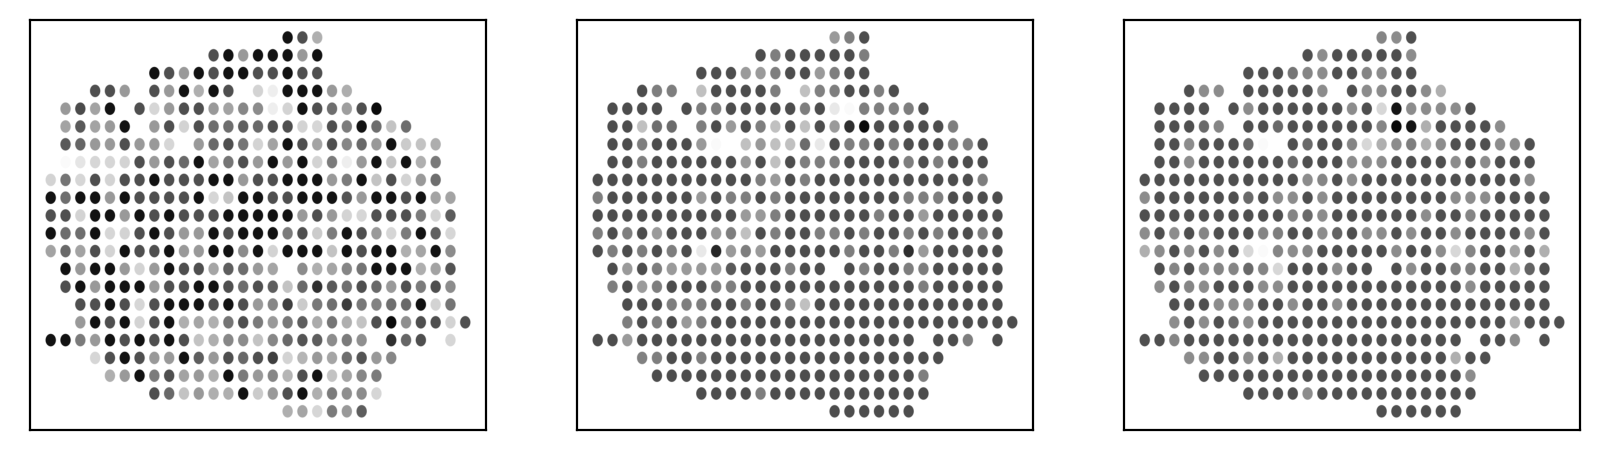

In [29]:
### 查看训练效果
n = 3  # 显示的记录数
plt.figure(dpi=200,figsize=(10, 7))
for i in range(n):
    # 显示原始图片
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x[i].reshape(720, 800))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [17]:
pre_test = model.predict(x_test)

/home/zkl/anaconda3/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2025-01-10 13:17:20.547685: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_transpose_3/Tanh' id:250 op device:{requested: '', assigned: ''} def:{{{node conv2d_transpose_3/Tanh}} = Tanh[T=DT_FLOAT, _has_manual_control_dependencies=true](conv2d_transpose_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [18]:
pre_test.shape

(100, 720, 800, 1)

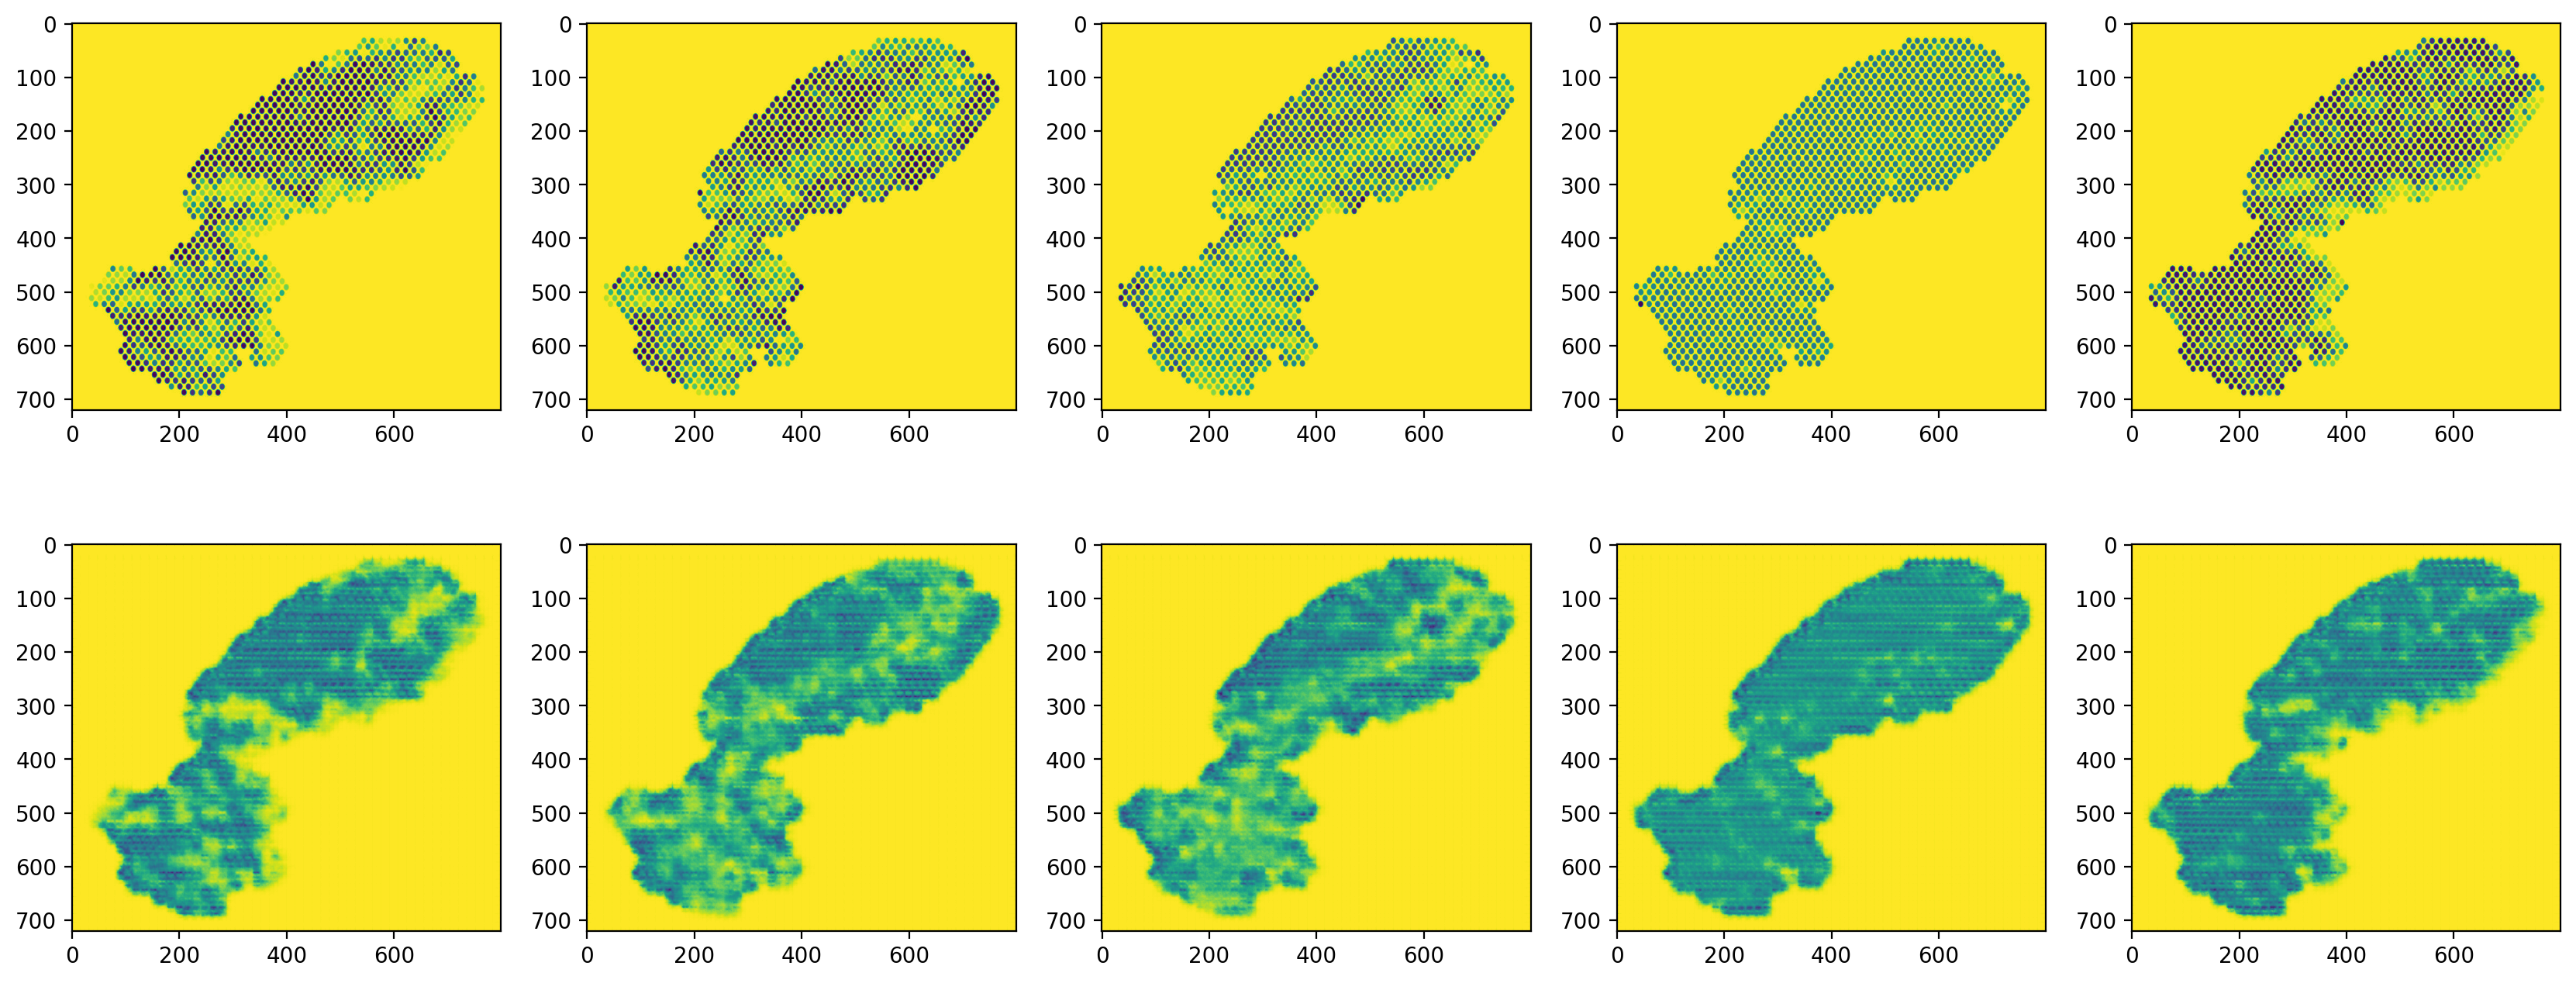

In [19]:
n = 6

plt.figure(dpi=200,figsize=(25,8))
for i in range(1,n):
    ax = plt.subplot(2,n,i)
    plt.imshow(x_test[i].reshape(720,800))
    ax = plt.subplot(2,n,i + n)
    plt.imshow(pre_test[i].reshape(720,800))

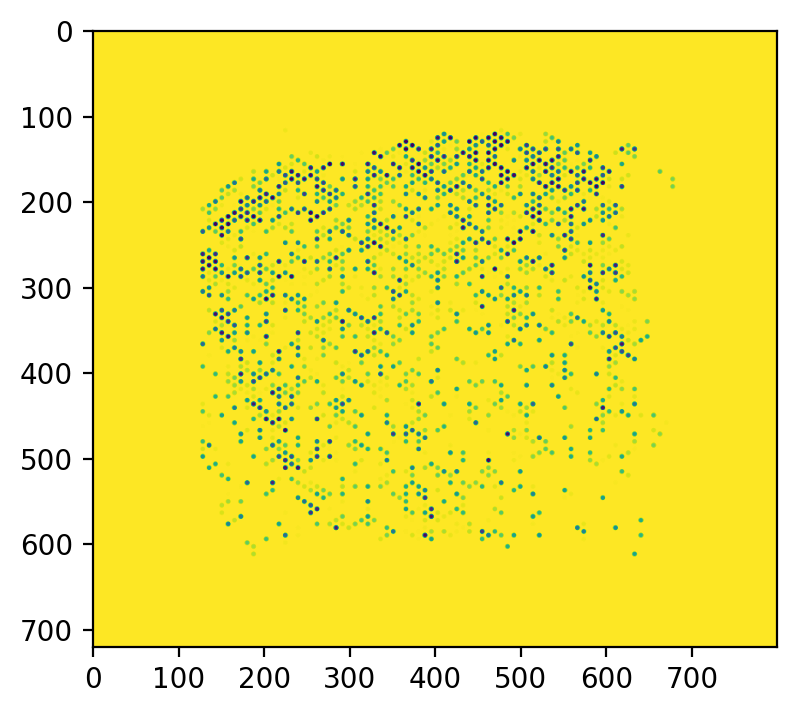

In [75]:
plt.figure(dpi=200,figsize=(6,4))
plt.imshow(x_test[0].reshape(720,800))

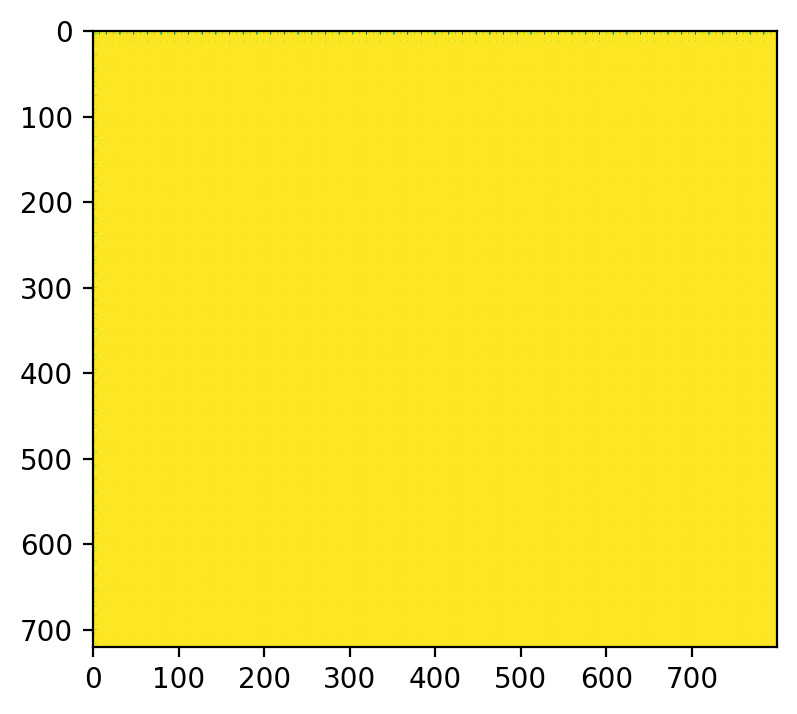

In [76]:
plt.figure(dpi=200,figsize=(6,4))
plt.imshow(pre_test[0].reshape(720,800))

In [20]:
model_name = 'Lung'

model.save("/home/zkl/Desktop/SViP_code/Model/" + model_name + ".h5")

encoder = tf.keras.Model(input, x8)
encoder.save('/home/zkl/Desktop/SViP_code/Model/' + model_name + '_encoder.h5')